# Rigorozní odhady prvního vlastního čísla p-laplaciánu 

## varianta $u_1$, $u_2$

Řešíme úlohu 
\begin{equation}
-\Delta_p u =\lambda |u|^{p-2}u, \; t \in (0,1)\\
u(0)=u(1)=0
\end{equation}
kde $\Delta_p u := \left(|u'|^{p-2}u' \right)'$.

Přesná hodnota prvního vlastního čísla je:

$$\lambda_1 = (p-1)\left( \frac{2\frac{\pi/p}{\sin{\pi/p}}}{b-a} \right)^p,$$

přesná hodnota první vlastní funkce:

$$e_p =(p-1)^{-\frac{1}{p}} \sin_p{\left( \pi_p\frac{x-a}{b-a} \right)}$$


![vl-cislo-fce](vl-cislo-fce.png)

### Algoritmus:
1. úlohu vyřešit numericky metodou střelby
2. získané řešení $u_1 := u$ a $u_2 := |u_1'|^{p-2}u_1'$ proložit intervalově křivkou (kubický spline?)
3. $v$ zderivovat - půjde snadno, je to polynom
4. dosadit do vztahu pro horní/dolní odhad a intervalově vypočítat

#### Postup pro řešení pomocí shooting method:
- převedu na soustavu:
\begin{equation}
u_1' = |u_2|^{\frac{p}{p-1}-2} u_2\\
u_2' = -\lambda |u_1|^{p-2}u_1
\end{equation}
- tu řeším jako IVP s levou okrajovou podmínkou a nějakým pevným $\lambda$
- bisekcí měním $\lambda$ až se napravo dostanu kam potřebuju ($u_1=0$)


#### Problémy:
- je vůbec možné použít $u_2$? Je to zaručená derivace vnitřku $\Delta_p u$?
- u kubického splinu pro $u_1$ chci nastavit duhou derivaci na $-1$. Co to ale znamená pro křivku proloženou numerickým řešení $u_2$ vzhledem k $p$ a $\Delta_p$?

In [1]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using DataInterpolations
using LinearAlgebra
using ForwardDiff

Nejprve si nastavím $p=3$. Zatím pracuji jen s $p>2$ a s $p \in \mathbb{N}$.

In [2]:
# nastavení p a přesná hodnota λ₁
P=3
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

28.28876197600255

Numerické řešení přes střelbu. 

Počáteční podmínka nastavena na $\boldsymbol{u}_0 = (0, 1)$, časový krok $\Delta t = 0.01$

---

Zatím to vypadá, že řešení IVP v Julii funguje jen pro P>=2 (případ P=2 nás ale vlastně nezajímá). Zjistit, proš nefunguje řešení pro 1<P<2

- důvod je v tom, že počáteční podmínka pro $u_1$ je $u_1(0)=0$ a tak v druhé rovnici hned na začátku dělím nulou. Řešením je to trochu posunout nahoru, ale to je pak řešení úplně blbě. Zkusím to ještě konfigurací řešiče
    - možná by stačilo nějak řešiči říct, ať to _neřeší_ v prvním bodě, někdo to v těch parametrech bylo

Numericky získané první vlastní číslo λ₁: 28.28876197305467
Chyba proti přesnému řešení: 2.9478819385531096e-9


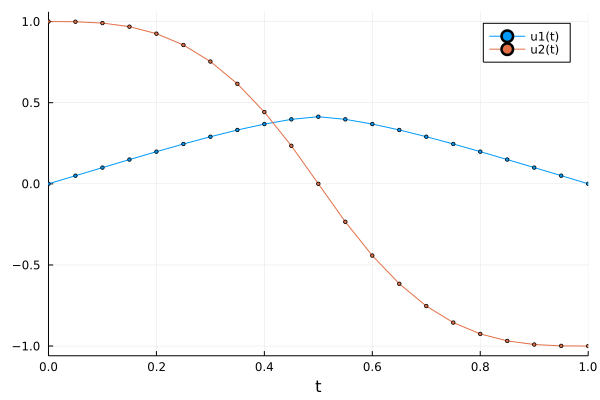

In [3]:
# řešení diferenciální soustavy metodou střelby

function sl(du,u,p,t) # parametr p je odhad na λ₁ a p z p-laplacianu
    λ, r = p
    du[1] = abs(u[2])^(r/(r-1) - 2)*u[2]
	du[2] = -λ * abs(u[1])^(r-2)*u[1]
end

u0 = [0.0; 1.0;] # počáteční podmínka
tn = 21
ts = 1.0/(tn-1) #0.05 # časový krok

e = 1e-12 # zastavovací podmínka
a,b = (3.,40.)
s = (a + b)/2

while (b-a) >= e
    prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
    sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

    if sol(1)[1] == 0 # bere hodnotu v t=1 (pravej konec) pro první řešení soustavy u₁
        break
    else
        probA = ODEProblem(sl, u0, (0.0, 1.0), (a, P))
        solA = solve(probA, saveat=ts, abstol=1e-8,reltol=1e-8)
        
        probS = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
        solS = solve(probS, saveat=ts, abstol=1e-8,reltol=1e-8)

        if solA(1)[1] * solS(1)[1] < 0
            b = s
        else
            a = s
        end
        s = (a+b)/2
    end
end
    
prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

println("Numericky získané první vlastní číslo λ₁: $s")
println("Chyba proti přesnému řešení: $(λ1-s)")
plot(sol,marker=2)

Vytáhnu si řešení do proměnných t, u1, u2. K u1 přičtu nějakou malou hodnotu aby posléze spline nelezl intervalově pod $0$. 

In [4]:
to_add = 0.05

t = sol.t
#t_dom = 0..1
#ti = mince(t_dom, tn)
ti = [@interval(i) for i in t]

u1 = [u[1]+to_add for u in sol.u]
u1i = [@interval(u[1]+to_add) for u in sol.u]
u1i[end]=@interval(to_add)

u2 = [u[2] for u in sol.u]
u2i = [@interval(u[2]) for u in sol.u];

#plot(t,u1, marker=2)
#plot!(t,u2,marker=2)



Intervalově vypočítáme kubický spline pro obě numerická řešení $u_1$, $u_2$.

In [5]:
# nejdřív u1

#matice A
n=length(u1i)
dv = [4 for i in 1:n-2]
ev = [1 for i in 1:n-3]
A = Array(SymTridiagonal(dv,ev))
A_inv = inv(A) #inverze

#pravá strana
h = ts
# sestavení pravé strany
rhs = []
for i in 3:length(u1)
    append!(rhs, 6/h^2 * (u1i[i] - 2 * u1i[i-1] + u1i[i-2]))
end

# vypočte vektor druhých derivací potřebný na výpočet koeficientů
# druhá derivace na krajích by měla být nastavena na -1, ale zatím nevím co s tím. Takže nastavím na 0

d2v = Interval[]
append!(d2v, @interval(0))
append!(d2v, A_inv*rhs)
append!(d2v, @interval(0));

# výpočet koeficientů jednotlivých oblouků splinu
csc_u1 = [] #@interval zeros(4, length(solu)-1)
for i in 1:length(u1i)-1
    a=b=c=d=0
    a = (d2v[i+1]-d2v[i])/(6*h)
    b = d2v[i]/2 
    c = (u1i[i+1] - u1i[i])/h - h*(2*d2v[i]+d2v[i+1])/6
    d = u1i[i]
    append!(csc_u1, [[a,b,c,d]])
    #csc[1, i] = a
end
csc_u1

20-element Vector{Any}:
 Interval{Float64}[[-0.0927738, -0.0927737], [0, 0], [1.00008, 1.00009], [0.0499999, 0.0500001]]
 Interval{Float64}[[-0.361848, -0.361847], [-0.0139161, -0.013916], [0.999388, 0.999389], [0.0999926, 0.0999927]]
 Interval{Float64}[[-0.59057, -0.590569], [-0.0681932, -0.0681931], [0.995283, 0.995284], [0.149882, 0.149883]]
 Interval{Float64}[[-0.864444, -0.864443], [-0.156779, -0.156778], [0.984034, 0.984035], [0.199401, 0.199402]]
 Interval{Float64}[[-1.09274, -1.09273], [-0.286446, -0.286445], [0.961873, 0.961874], [0.248103, 0.248104]]
 Interval{Float64}[[-1.66924, -1.66923], [-0.450356, -0.450355], [0.925033, 0.925034], [0.295344, 0.295345]]
 Interval{Float64}[[-1.35319, -1.35318], [-0.700741, -0.70074], [0.867478, 0.867479], [0.340261, 0.340262]]
 Interval{Float64}[[-5.31898, -5.31897], [-0.903719, -0.903718], [0.787255, 0.787256], [0.381714, 0.381715]]
 Interval{Float64}[[3.8755, 3.87551], [-1.70157, -1.70156], [0.656991, 0.656992], [0.418153, 0.418154]]
 In

Intervalově spline vykreslíme, každý oblouk dělím na xn intervalů.

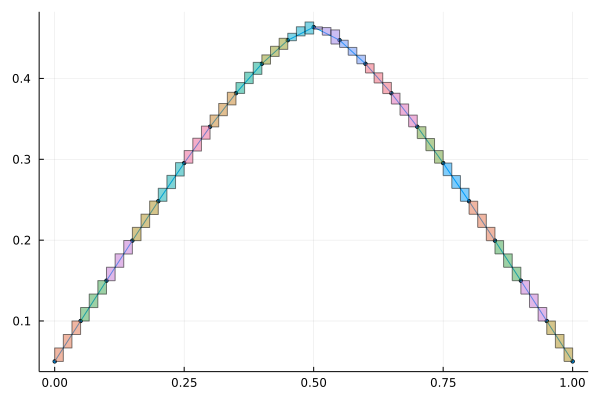

In [6]:
# vykreslení řešení aproximovaného přes kubický spline u1

xn = 3

p = plot(t,u1, marker=2)
for i in 1:length(u1)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    f(x) = csc_u1[i][1]*(x-ti[i])^3 + csc_u1[i][2]*(x-ti[i])^2 + csc_u1[i][3]*(x-ti[i]) + csc_u1[i][4]
    boxes = IntervalBox.(x_int, f.(x_int))    
    plot!(boxes, legend=false)
end
p


In [7]:
# teďkon v

#matice A
n=length(u2i)
dv = [4 for i in 1:n-2]
ev = [1 for i in 1:n-3]
A = Array(SymTridiagonal(dv,ev))
A_inv = inv(A) #inverze

#pravá strana
h = ts
# sestavení pravé strany
rhs = []
for i in 3:length(u2i)
    append!(rhs, 6/h^2 * (u2i[i] - 2 * u2i[i-1] + u2i[i-2]))
end

# vypočte vektor druhých derivací potřebný na výpočet koeficientů
# druhá derivace na krajích je nastavena na -1

d2v = []
append!(d2v, -1)
append!(d2v, A_inv*rhs)
append!(d2v, -1);

# výpočet koeficientů jednotlivých oblouků splinu
csc_u2 = [] #@interval zeros(4, length(solu)-1)
for i in 1:length(u2i)-1
    a=b=c=d=0
    a = (d2v[i+1]-d2v[i])/(6*h)
    b = d2v[i]/2 
    c = (u2i[i+1] - u2i[i])/h - h*(2*d2v[i]+d2v[i+1])/6
    d = u2i[i]
    append!(csc_u2, [[a,b,c,d]])
    #csc[1, i] = a
end
csc_u2

20-element Vector{Any}:
 Interval{Float64}[[-6.09576, -6.09575], [-0.5, -0.5], [0.0166689, 0.016669], [1, 1]]
 Interval{Float64}[[-9.34592, -9.34591], [-1.41437, -1.41436], [-0.070716, -0.0707159], [0.998821, 0.998822]]
 Interval{Float64}[[-9.01435, -9.01434], [-2.81626, -2.81625], [-0.282247, -0.282246], [0.990581, 0.990582]]
 Interval{Float64}[[-8.25443, -8.25442], [-4.16841, -4.1684], [-0.63148, -0.631479], [0.968301, 0.968302]]
 Interval{Float64}[[-6.94466, -6.94465], [-5.40657, -5.40656], [-1.11023, -1.11022], [0.925274, 0.925275]]
 Interval{Float64}[[-4.71539, -4.71538], [-6.44827, -6.44826], [-1.70297, -1.70296], [0.855379, 0.85538]]
 Interval{Float64}[[-2.04301, -2.043], [-7.15558, -7.15557], [-2.38317, -2.38316], [0.75352, 0.753521]]
 Interval{Float64}[[4.02746, 4.02747], [-7.46203, -7.46202], [-3.11405, -3.11404], [0.616218, 0.616219]]
 Interval{Float64}[[4.67092, 4.67093], [-6.85791, -6.8579], [-3.83004, -3.83003], [0.442364, 0.442365]]
 Interval{Float64}[[41.049, 41.0491], 

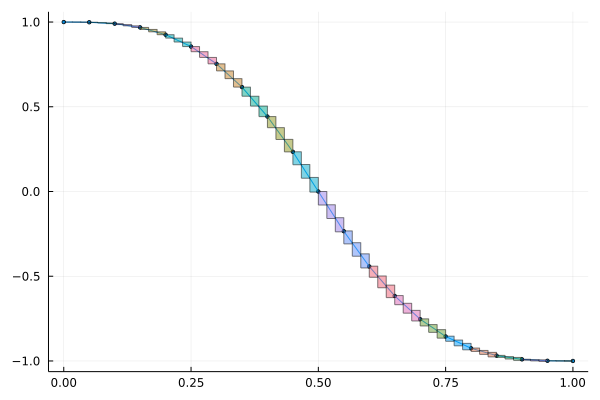

In [8]:
# vykreslení řešení aproximovaného přes kubický spline

xn = 3

p = plot(t,u2, marker=2)
for i in 1:length(u2i)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    f(x) = csc_u2[i][1]*(x-ti[i])^3 + csc_u2[i][2]*(x-ti[i])^2 + csc_u2[i][3]*(x-ti[i]) + csc_u2[i][4]
    boxes = IntervalBox.(x_int, f.(x_int))    
    plot!(boxes, legend=false)
end
p

Derivace $u_2$

In [9]:
csc_u2der =[ [@interval(3) * cs[1], @interval(2) * cs[2], cs[3]] for cs in csc_u2 ]

20-element Vector{Vector{Interval{Float64}}}:
 [[-18.2873, -18.2872], [-1, -1], [0.0166689, 0.016669]]
 [[-28.0378, -28.0377], [-2.82873, -2.82872], [-0.070716, -0.0707159]]
 [[-27.0431, -27.043], [-5.63251, -5.6325], [-0.282247, -0.282246]]
 [[-24.7633, -24.7632], [-8.33681, -8.3368], [-0.63148, -0.631479]]
 [[-20.834, -20.8339], [-10.8132, -10.8131], [-1.11023, -1.11022]]
 [[-14.1462, -14.1461], [-12.8966, -12.8965], [-1.70297, -1.70296]]
 [[-6.12903, -6.12902], [-14.3112, -14.3111], [-2.38317, -2.38316]]
 [[12.0823, 12.0824], [-14.9241, -14.924], [-3.11405, -3.11404]]
 [[14.0127, 14.0128], [-13.7159, -13.7158], [-3.83004, -3.83003]]
 [[123.147, 123.148], [-12.3146, -12.3145], [-4.4808, -4.48079]]
 [[123.142, 123.143], [0.000174573, 0.000174574], [-4.78866, -4.78865]]
 [[14.0139, 14.014], [12.3144, 12.3145], [-4.48079, -4.48078]]
 [[12.082, 12.0821], [13.7158, 13.7159], [-3.83004, -3.83003]]
 [[-6.12895, -6.12894], [14.924, 14.9241], [-3.11404, -3.11403]]
 [[-14.1462, -14.1461], [14.

Dolní odhad λ₁: 25.532271069041087
Chyba proti přesné hodnotě λ₁: 2.7564909069614636


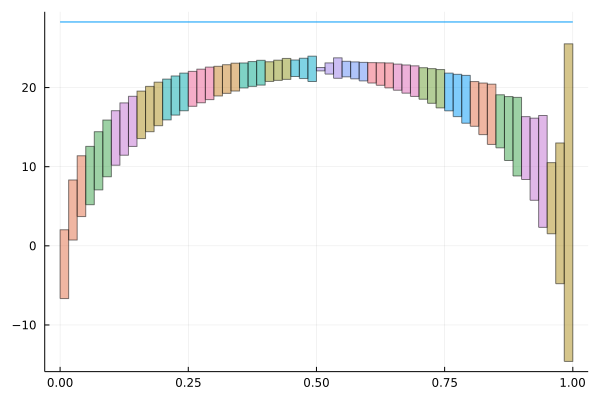

In [14]:
# výpočet λ₁ - dolní odhad

# vykreslení řešení aproximovaného přes kubický spline

ls = []

xn = 3

p = plot(t, [λ1 for i in t])
for i in 1:length(u2i)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    
    u1_spl(x) = csc_u1[i][1]*(x-ti[i])^3 + csc_u1[i][2]*(x-ti[i])^2 + csc_u1[i][3]*(x-ti[i]) + csc_u1[i][4]

    u2der_spl(x) = csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3]

    f(x) = -u2der_spl(x) / u1_spl(x)^(P-1)
    #println(-v_spl_der_i(x_int[1]))
    #println(u_spl_i(x_int[1]))
    boxes = IntervalBox.(x_int, f.(x_int))    
    plot!(boxes, legend=false)
    # kromě vykreslení sem musím ještě dodat záznam minim
    append!(ls, sup.(f.(x_int)))
    
end
println("Dolní odhad λ₁: $(maximum(ls))")
println("Chyba proti přesné hodnotě λ₁: $(λ1 - maximum(ls))")
p


# Spline přes DataInterpolations.jl

- neumi ale nastavit druhou derivaci na koncích, navíc to neni intervalově :-(

In [129]:
# proložení splinem - pomocí DataInterpolations
# tady si ale nejsem schopen nastavit správně krajní záporné druhé derivace

u_spl = CubicSpline(u1,t);
v_spl = CubicSpline(u2,t);


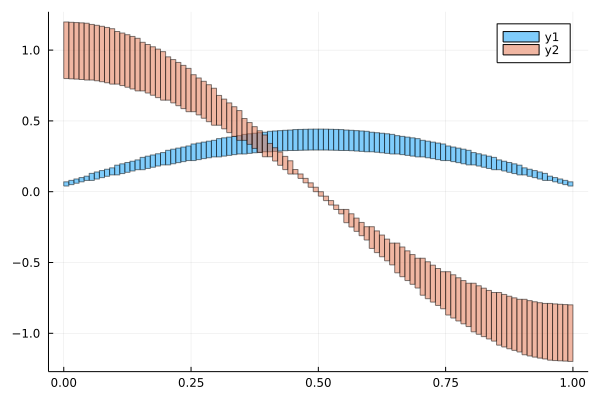

In [130]:
#vykreslení funkce intervalově
x_dom = 0..1
x_int = mince(x_dom,100)

boxes_u = IntervalBox.(x_int, u_spl.(x_int))
boxes_v = IntervalBox.(x_int, v_spl.(x_int))
plot(boxes_u)
plot!(boxes_v)

In [131]:
v_spl_der(x) = ForwardDiff.derivative(v_spl,x)

v_spl_der (generic function with 1 method)

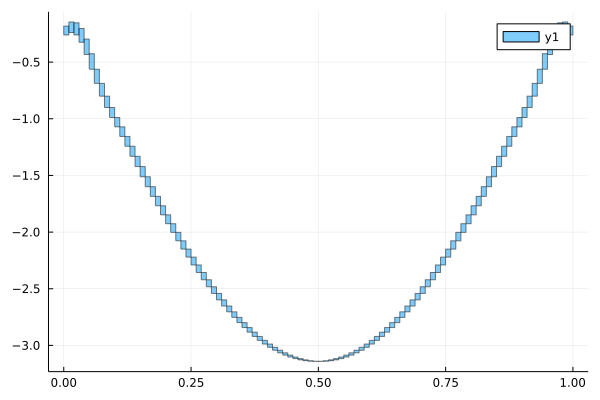

In [132]:
x_dom = 0..1
x_int = mince(x_dom,100)

boxes = IntervalBox.(x_int, v_spl_der.(x_int))
plot(boxes)

In [133]:
l_low(x) = -v_spl_der(x) / u_spl(x)^(P-1)

l_low (generic function with 1 method)

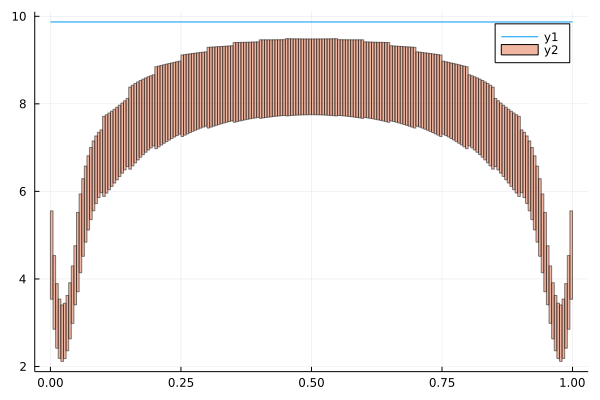

In [143]:
x_dom = 0..1
x_int = mince(x_dom,200)

boxes = IntervalBox.(x_int, l_low.(x_int))
plot(t, [λ1 for i in t])
plot!(boxes)


In [141]:
l_low(0..1)

[-∞, ∞]